# Simple Convolutional 1D

In [186]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [187]:
class Initializer:
    def __init__(self, sigma=0.02):
        self.sigma = sigma
    def W(self, n_nodes1, n_nodes2):
      """
      Weight initialization
      Parameters
      ----------
      n_nodes1 : int
        Number of nodes in the previous layer
      n_nodes2 : int
        Number of nodes in the later layer
      Returns
      ----------
      W :
      """
      pass
    def B(self, n_nodes2):
      """
      Bias initialization
      Parameters
      ----------
      n_nodes2 : int
        Number of nodes in the later layer
      Returns
      ----------
      B :
      """
      pass
class SimpleInitializer(Initializer):
    def W(self, n_nodes1, n_nodes2):
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)
    
    def B(self, n_nodes2):
        return self.sigma * np.random.randn(n_nodes2)

class XavierInitializer(Initializer):
    def W(self, n_nodes1, n_nodes2):
        return self.sigma * np.random.normal(scale=np.sqrt(1/(n_nodes1+n_nodes2)), size=(n_nodes1, n_nodes2))

    def B(self, n_nodes2):
        return self.sigma * np.random.normal(scale=np.sqrt(1/n_nodes2), size=n_nodes2)


class HeInitializer(Initializer):
    def W(self, n_nodes1, n_nodes2):
        return self.sigma * np.random.normal(scale=np.sqrt(2/(n_nodes1+n_nodes2)), size=(n_nodes1, n_nodes2))
        # return self.sigma * np.random.normal( size=(n_nodes1, n_nodes2))

    def B(self, n_nodes2):
        return self.sigma * np.random.normal(scale=np.sqrt(2/n_nodes2), size=n_nodes2)
        # return self.sigma * np.random.normal(size=n_nodes2)

In [188]:
class Optimizer:
    def __init__(self, lr=0.01):
        self.lr = lr
    def update(self, layer):
        """
        Update weights and biases for a layer
        Parameters
        ----------
        layer : Instance of the layer before update
        """
        pass

class SGD(Optimizer):
    def update(self, layer):
        layer.B -= self.lr*layer.dB
        layer.W -= self.lr*layer.dW

class AdaGrad(Optimizer):
    def __init__(self, lr=0.01):
        self.lr = lr
        self.hW = 0
        self.hB = 0
    def update(self, layer):
        self.hW += layer.dW ** 2
        self.hB = layer.dB ** 2

        layer.W -= self.lr * layer.dW / (np.sqrt(self.hW) + 1e-7)
        layer.B -= self.lr * layer.dB / (np.sqrt(self.hB) + 1e-7)

In [189]:
class Tanh:
    def forward(self, A):
      self.A = A
      return np.tanh(A)
    
    def backward(self, dZ):
      return dZ * (1 - np.power(np.tanh(self.A),2))

class Sigmoid:
    def __sigmoid(self, X):
      return 1 / ( 1 + np.exp(-X) ) 
    def forward(self, A):
      self.A = A
      return self.__sigmoid(A)
    
    def backward(self, dZ):
      return dZ * (1 - self.__sigmoid(self.A)) * self.__sigmoid(self.A)

class ReLu:
    def forward(self, A):
      self.A = A
      return np.maximum(A, 0)
    
    def backward(self, dZ):
      return dZ * ((self.A > 0) * 1)

class Softmax:
    def forward(self, X):
      e = np.exp(X)
      return e / np.sum(e, axis=1).reshape(-1,1)
    
    def backward(self, Yhat, Y):
      n_batches = Yhat.shape[0]
      return (Yhat-Y)/n_batches

In [190]:
class FC:
    def __init__(self, n_nodes1, n_nodes2, initializer,
                 activation, optimizer, bias=True):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.initializer = initializer
        self.activation = activation
        self.optimizer = optimizer
        self.bias = bias
        self._init_weights()
    
    def _init_weights(self):
        self.W = self.initializer.W(self.n_nodes1, self.n_nodes2)
        self.B = self.initializer.B(self.n_nodes2)
        
    def forward(self, X):
        self.input = X
        self.A = np.matmul(X, self.W) + self.B if self.bias else np.matmul(X, self.W)
        return self.activation.forward(self.A)

    def backward(self, y_pred, y_true=None):
        if isinstance(self.activation, Softmax):
            dA = self.activation.backward(y_pred, y_true)
        else:
            dA = self.activation.backward(y_pred)

        self.dW = self.input.T @ dA / len(self.input)
        self.dB = np.mean(dA, axis=0)
        dZ = np.dot(dA, self.W.T)
        
        self.optimizer.update(self)
        return dZ

In [191]:
class GetMiniBatch:
    def __init__(self, X, y, batch_size=20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

# **Problem 1** Creating a one-dimensional convolutional layer class that limits the number of channels to one

In [192]:
def forward(X, W, B):
    filter_size = len(X) - len(W) + 1

    a = np.zeros(shape=(filter_size,))

    for i in range(filter_size):
        a[i] = np.sum(X[i:i + len(W)] * W) + B
    return a

def backward(X, W, dA):
    if dA.ndim == 1:
        dB = np.array([np.sum(dA)])
    else:
        dB = np.sum(dA, axis=1)

    dW = np.zeros(len(W))
    for i in range(len(W)):
        dW[i] = np.sum(X[i:i+len(dA)] * dA)

    zero = np.zeros(len(dA) - 1)
    padding_W = np.concatenate([zero, W, zero], axis=0)
    dX = np.zeros(len(X))
    for i in range(len(X)):
        dX[i] = np.sum(padding_W[i:i+len(dA)] * dA[::-1])

    return dB, dW, dX

# **Problem 2:** Output size calculation after one-dimensional convolution

In [193]:
def output_shape(n_in, filter_size, padding=0, stride=1):
    shape = (n_in + 2*padding - filter_size) / stride + 1
    return int(shape)

# **Problem 3:** Experiment of one-dimensional convolutional layer with small array

In [194]:
x = np.array([1,2,3,4])
w = np.array([3,5,7])
b = np.array([1])
delta_a = np.array([10, 20])

In [195]:
output_shape(4, 3, 0, 1)

2

In [196]:
print('forward pass:', forward(x, w, b))
print('backward pass:', backward(x, w, delta_a))

forward pass: [35. 50.]
backward pass: (array([30]), array([ 50.,  80., 110.]), array([ 30., 110., 170., 140.]))


# **Problem 4:** Creating a one-dimensional convolutional layer class that does not limit the number of channels

In [197]:
# Shape (2, 4): (number of input channels, number of features)
x = np.array([[1, 2, 3, 4],
              [2, 3, 4, 5]])

# Shape: (number of output channels, number of input channels, filter_size)
w = np.ones((3, 2, 3))

# Shape: (number of output channels)
b = np.array([1, 2, 3])

In [198]:
def forward_with_channel(X, W, B):
    out_feature_size = output_shape(X.shape[1], W.shape[2])
    A = np.zeros((W.shape[0], out_feature_size))

    for out_channel in range(W.shape[0]):
        for in_channel in range(W.shape[1]):
            for i in range(out_feature_size):
                A[out_channel, i] += np.sum(X[in_channel, i:i + W.shape[2]] * W[out_channel, in_channel, :])

    A += B[:, np.newaxis]
    return A

def backward_with_channel(X, W, B, dA):
    if dA.ndim == 1:
        dB = np.array([np.sum(dA)])
    else:
        dB = np.sum(dA, axis=1)

    dW = np.zeros(W.shape)
    for out_channel in range(W.shape[0]):
        for in_channel in range(W.shape[1]):
            for fs in range(W.shape[2]):
                dW[out_channel, in_channel, fs] += np.sum(X[in_channel, fs:fs + dA.shape[1]] * dA[out_channel])
    
    dX = np.zeros(X.shape)
    for out_channel in range(W.shape[0]):
        for in_channel in range(W.shape[1]):
            for fs in range(W.shape[2]):
                for m in range(dA.shape[1]):
                    dX[in_channel, fs + m] += W[out_channel, in_channel, fs] * dA[out_channel, m]
    
    return dW, dB, dX

In [199]:
forward_with_channel(x, w, b)

array([[16., 22.],
       [17., 23.],
       [18., 24.]])

#**Problem 5:** (Advanced task) Implementing padding

In [200]:
def pad(X, padding=0):
    return np.pad(X, padding, "constant")

In [201]:
pad([1, 2, 3, 4, 5], 1)

array([0, 1, 2, 3, 4, 5, 0])

In [202]:
a = [[1, 2, 3],
     [4, 5, 6],
     [7, 8, 9]]
pad(a, 3)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 2, 3, 0, 0, 0],
       [0, 0, 0, 4, 5, 6, 0, 0, 0],
       [0, 0, 0, 7, 8, 9, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

# **Problem 6:** (Advanced task) Response to mini batch

In [203]:
class SimpleInitializerConv1d:
    def __init__(self, sigma=0.02, seed=None):
        self.sigma = sigma
        self.seed = seed
        np.random.seed(seed)

    def W(self, *shape):
        W = self.sigma * np.random.randn(*shape)
        return W

    def B(self, *shape):
        B = self.sigma * np.random.randn(*shape)
        return B

In [204]:
class SimpleConv1d:
    def __init__(self, out_channel, in_channel, filter_size,
                 padding=0, stride=1, initializer=None,
                 optimizer=None, activation=None):
        self.out_channel = out_channel
        self.in_channel = in_channel
        self.filter_size = filter_size
        self.padding = padding
        self.stride = stride

        self.initializer = initializer
        self.optimizer = optimizer
        self.activation = activation
        self._init_weights()

    def _init_weights(self):
        self.W = self.initializer.W(self.out_channel, self.in_channel, self.filter_size)
        self.B = self.initializer.B(self.out_channel)
    
    def _output_shape(self, n_features):
        return int((n_features + 2 * self.padding - self.filter_size) / self.stride + 1)
    
    def forward(self, X):
        self.input = X
        self.N, self.in_channel, n_features = X.shape
        self.OUT = self._output_shape(n_features)

        self.A = np.zeros((self.N, self.out_channel, self.OUT))
        for n in range(self.N):
            for out_channel in range(self.out_channel):
                for in_channel in range(self.in_channel):
                    pad_X = np.pad(self.input[n, in_channel], self.padding)
                    for m in range(self.OUT):
                        stride_m = m * self.stride
                        self.A[n, out_channel, m] += np.sum(pad_X[stride_m:stride_m + self.filter_size] * self.W[out_channel, in_channel, :])

        self.A += self.B[:, None]
        self.output = self.activation.forward(self.A)
        return self.output
    
    def backward(self, d):
        dA = self.activation.backward(d)

        # Gradient B
        self.dB = np.mean(np.sum(dA, axis=2), axis=0)

        # Gradient W, X
        self.dW = np.zeros(self.W.shape)
        dZ = np.zeros((*self.input.shape[:-1], self.input.shape[-1] + 2 * self.padding))

        for n in range(self.N):
            for out_channel in range(self.out_channel):
                for in_channel in range(self.in_channel):
                    pad_X = np.pad(self.input[n, in_channel], self.padding)
                    for fs in range(self.filter_size):
                        for m in range(self.OUT):
                            stride_m = m * self.stride
                            self.dW[out_channel, in_channel, fs] += pad_X[fs + stride_m] * dA[n, out_channel, m]
                            dZ[n, in_channel, fs + stride_m] += self.W[out_channel, in_channel, fs] * dA[n, out_channel, m]
        
        if self.padding > 0:
            dZ = dZ[:, :, self.padding:-self.padding]

        self.optimizer.update(self)
        return dZ

# **Problem 7:** (Advance assignment) Arbitrary number of strides

In [205]:
def forward_with_strides(X, W, B, padding=0, stride=1):
    out_feature_size = output_shape(X.shape[1], W.shape[2], padding, stride)
    A = np.zeros((W.shape[0], out_feature_size))

    for out_channel in range(W.shape[0]):
        for in_channel in range(W.shape[1]):
            for i in range(0, out_feature_size):
                X_padded = pad(X[in_channel], padding)
                idx = i * stride
                A[out_channel, i] += np.sum(X_padded[idx:idx + W.shape[2]] * W[out_channel, in_channel, :])

    A += B[:, None]
    return A

def backward_with_strides(X, W, B, dA, padding=0, stride=1):
    if dA.ndim == 1:
        dB = np.array([np.sum(dA)])
    else:
        dB = np.sum(dA, axis=1)

    dW = np.zeros(W.shape)
    dX = np.zeros((*X.shape[:-1], X.shape[-1] + 2*padding))
    for out_channel in range(W.shape[0]):
        for in_channel in range(W.shape[1]):
            for fs in range(W.shape[2]):
                for i in range(dA.shape[1]):
                    X_padded = pad(X[in_channel], padding)
                    dW[out_channel, in_channel, fs] += X_padded[fs + i*stride] * dA[out_channel, i]
                    dX[in_channel, fs + i*stride] += W[out_channel, in_channel, fs] * dA[out_channel, i]

    if padding > 0:
        dX = dX[:, padding:-padding]
    return dW, dB, dX

In [206]:
x = np.array([[1, 2, 3, 4],
              [2, 3, 4, 5]])

w = np.ones((3, 2, 3))

b = np.array([1, 2, 3])

dA = np.array([[9, 11, 10],
               [32, 35, 30],
               [52, 56, 50]])

In [207]:
forward_with_strides(x, w, b, 0, 1)

array([[16., 22.],
       [17., 23.],
       [18., 24.]])

In [208]:
forward_with_strides(x, w, b, 1, 1)

array([[ 9., 16., 22., 17.],
       [10., 17., 23., 18.],
       [11., 18., 24., 19.]])

In [209]:
backward_with_strides(x, w, b, dA, 2, 2)

(array([[[ 41.,  62.,  42.],
         [ 62.,  83.,  62.]],
 
        [[125., 190., 137.],
         [190., 255., 204.]],
 
        [[206., 312., 220.],
         [312., 418., 328.]]]),
 array([ 30,  97, 158]),
 array([[195., 102., 192.,  90.],
        [195., 102., 192.,  90.]]))

#**Problem 8** Learning and estimation

In [231]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score

def plot_learning_curve(train_loss, val_loss=None):
    plt.figure(figsize=(16, 8))
    plt.plot(train_loss, label="train_loss", linewidth=5)
    if val_loss is not None:
        plt.plot(val_loss, label="val_loss", linewidth=5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

In [211]:
class ScratchCNNClassifier:
    def __init__(self, batch_size=1, epochs=10, CNN=[], FC=[],
                 random_state=None, verbose=False):
        self.batch_size = batch_size
        self.epochs = epochs
        self.CNN = CNN.copy()
        self.FC = FC.copy()
        self.random_state = random_state
        self.verbose = verbose
    
    def add(self, layer):
        if isinstance(layer, SimpleConv1d):
            self.CNN.append(layer)
        elif isinstance(layer, FC):
            self.FC.append(layer)

    def loss_function(self, y_true, y_proba, tol=1e-7):
        L = -np.mean(y_true * np.log(y_proba + tol))
        return L
    
    def _feedforward(self, X):
        Z = X.reshape(self.batch_size, 1, -1)
        for layer in self.CNN:
            Z = layer.forward(Z)
        self.cnn_out_shape = Z.shape
        Z = Z.reshape(self.batch_size, -1)
        for layer in self.FC:
            Z = layer.forward(Z)
        return Z
    
    def _backpropagation(self, dZ, y_true):
        dZ = self.FC[-1].backward(dZ, y_true)
        for layer in self.FC[-2::-1]:
            dZ = layer.backward(dZ)
        dZ = dZ.reshape(self.cnn_out_shape)
        for layer in self.CNN[::-1]:
            dZ = layer.backward(dZ)
        
    def fit(self, X, y, X_val=None, y_val=None):
        self.train_loss = []
        self.val_loss = []
        for i in range(self.epochs):
            mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=self.random_state)
            loss = 0
            for mini_X, mini_y in mini_batch:
                Z = self._feedforward(mini_X)
                self._backpropagation(Z, mini_y)
                
                # Accumulate loss
                l = self.loss_function(mini_y, Z)
                loss += l
                print("Loss", l)

            self.train_loss.append(loss / len(mini_batch))
            if X_val is not None and y_val is not None:
                self.val_loss.append(self.loss_function(y_val, self.predict_proba(X_val)))

            if self.verbose:
                print("Epoch", i, "Loss:", self.train_loss[-1])
        return self
    
    def predict_proba(self, X):
        Z = X[:, np.newaxis, :]
        for layer in self.CNN:
            Z = layer.forward(Z)
        Z = Z.reshape(len(X), -1)
        for layer in self.FC:
            Z = layer.forward(Z)
        return Z

    def predict(self, X):
        y_proba = self.predict_proba(X)
        return np.argmax(y_proba, axis=1)

In [212]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [213]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [214]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

In [215]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


In [216]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.transform(y_val[:, np.newaxis])
print(y_train.shape)
print(y_train_one_hot.shape) 
print(y_train_one_hot.dtype)

(48000,)
(48000, 10)
float64


In [225]:
FC1 = FC(15640, 200, initializer=HeInitializer(), activation=ReLu(), optimizer=AdaGrad())
FC2 = FC(200, 100, initializer=HeInitializer(), activation=ReLu(), optimizer=AdaGrad())
FC3 = FC(100, 10, initializer=SimpleInitializer(), activation=Softmax(), optimizer=AdaGrad())
conv1d = SimpleConv1d(out_channel=20, in_channel=1, filter_size=3, padding=0, stride=1,
                      initializer=SimpleInitializerConv1d(), optimizer=SGD(0.01), activation=ReLu())
model = ScratchCNNClassifier(batch_size=100, epochs=10, verbose=True)
model.add(conv1d)
model.add(FC1)
model.add(FC2)
model.add(FC3)

In [227]:
# Only train 1000 first examples because the training time is too long :(
model.fit(X_train[:1000], y_train_one_hot[:1000])

Loss 0.23021158030661007
Loss 0.23067163054012177
Loss 0.2301330285056489
Loss 0.22971580653426182
Loss 0.22981322115662345
Loss 0.23016865143021137
Loss 0.2304535131613948
Loss 0.230321865079178
Loss 0.2302835478044615
Loss 0.23097652078594003
Epoch 0 Loss: 0.2302749365304452
Loss 0.22965259704119423
Loss 0.22854616031580025
Loss 0.22853373294224585
Loss 0.23180599817210157
Loss 0.22880613534656716
Loss 0.23057815921545585
Loss 0.22917805219151893
Loss 0.22836774895138912
Loss 0.2282594198721557
Loss 0.22834639658155828
Epoch 1 Loss: 0.2292074400629987
Loss 0.2259009433400238
Loss 0.2281538942294337
Loss 0.22811386761517008
Loss 0.22741526547336352
Loss 0.22477687307208874
Loss 0.22532852102559692
Loss 0.2234817757083943
Loss 0.22341062731611128
Loss 0.22547978227726806
Loss 0.223182319493964
Epoch 2 Loss: 0.2255243869551414
Loss 0.22263226475552625
Loss 0.22135286744632357
Loss 0.21810515736914965
Loss 0.22411927914866417
Loss 0.22301687574127121
Loss 0.21801793593030055
Loss 0.21586

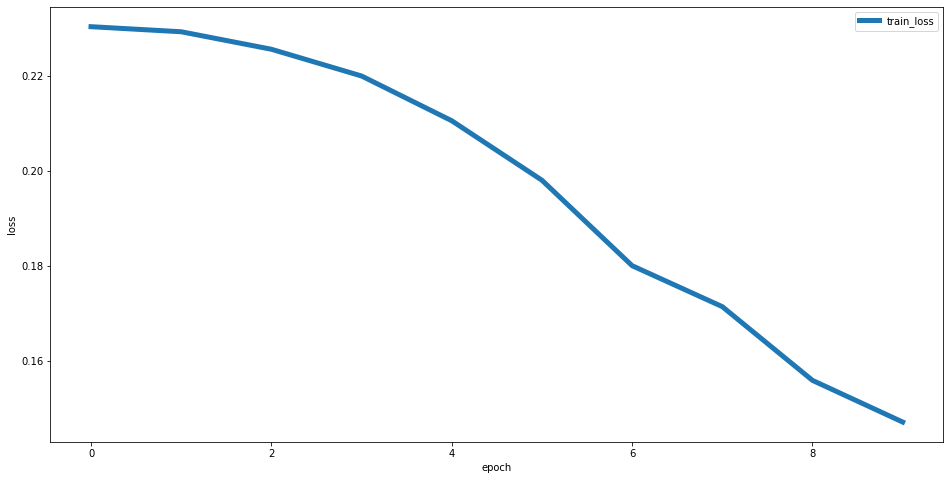

In [230]:
plot_learning_curve(model.train_loss)